# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. 
Данные для модели находятся в папке `/datasets/faces/`. Внутри этой папки есть одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. 

## Исследовательский анализ данных

In [1]:
import sys

import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
display(HTML("<style>.container { width:85% !important; }</style>")) #широкоформатный режим

In [3]:
#константы
RANDOM_STATE = 270923 #константа, инициализирующая генератор псевдослучайных чисел
PATH = '/datasets/faces' if sys.platform=='linux' else 'datasets/faces' #путь к файлам

Откроем файл `labels.csv` и запишем датафрейм в переменную `faces`.

In [4]:
faces = pd.read_csv(f'{PATH}/labels.csv')

Выведем основную информацию о датафрейме

In [5]:
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Выведем 10 случайных строк

In [6]:
faces.sample(10,random_state=RANDOM_STATE)

,file_name,real_age
3565,003565.jpg,17
2440,002440.jpg,30
2648,002648.jpg,21
1451,001451.jpg,26
3648,003648.jpg,50
1423,001423.jpg,14
932,000932.jpg,44
2701,002701.jpg,6
5097,005097.jpg,1
4844,004844.jpg,23


Построим распределение людей по возрастам

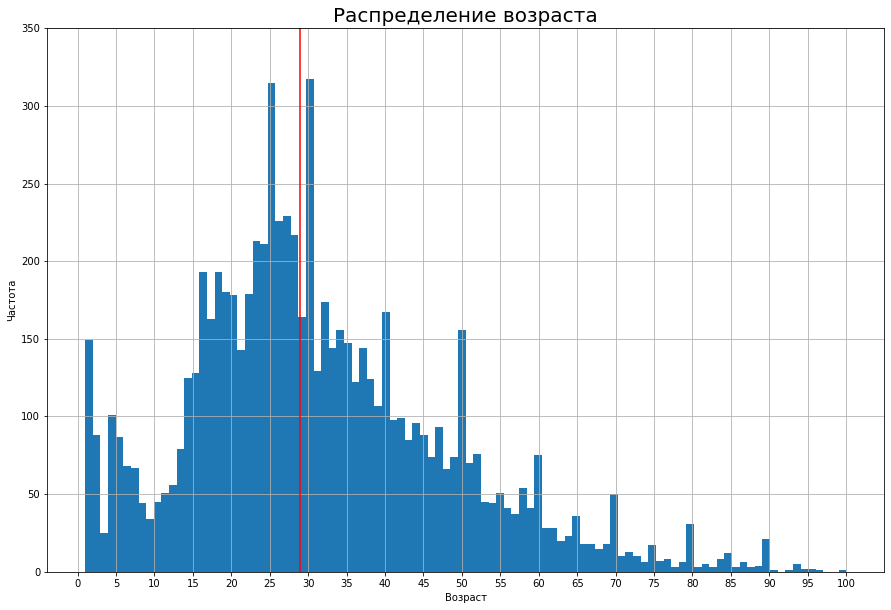

In [7]:
faces.real_age.hist(bins=100, figsize=(15,10));
plt.xlabel('Возраст');
plt.ylabel('Частота');
plt.title('Распределение возраста', fontdict={'fontsize':20});
plt.xticks(range(0,105,5));
plt.ylim(0,350);
plt.vlines(faces.real_age.median(),0,350, colors='red');

Выведем 15 случайных фотографий, используя загрузчик `ImageDataGenerator`

Found 7591 validated image filenames.


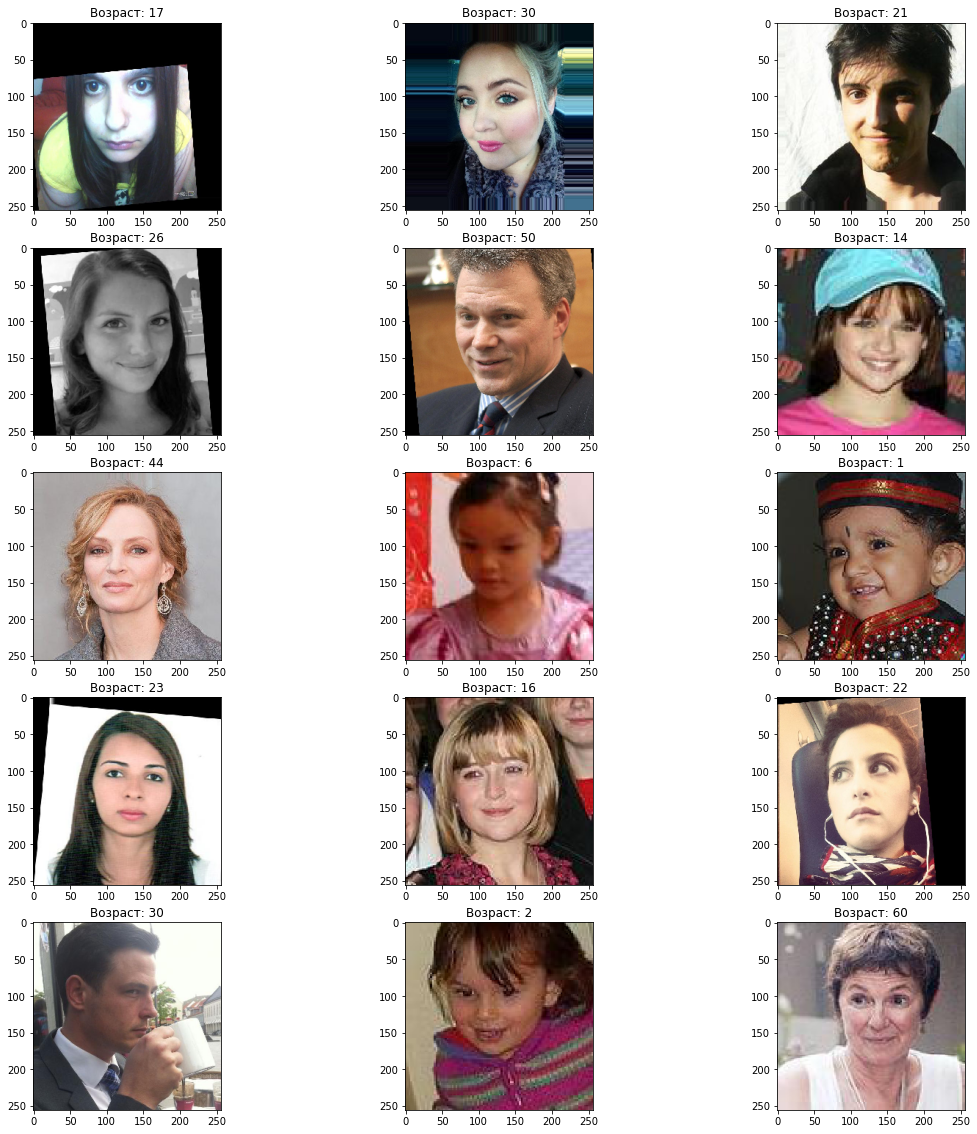

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
sample_faces = datagen.flow_from_dataframe(
    dataframe=faces,
    directory=f'{PATH}/final_files/',
    x_col='file_name',
    y_col='real_age',    
    batch_size=15,
    class_mode='raw',
    seed=RANDOM_STATE)

images, ages = next(sample_faces)
plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(5,3,i+1, title=f'Возраст: {ages[i]}')
    plt.imshow(images[i]) 
    
plt.subplots_adjust(wspace=0)

**Выводы:**
1. датафрейм `faces` содержит 7591 строку и 2 столбца;
1. в основном фотографии нормально ориентированные, поэтому поворот не требуется;
1. представленные фотографии цветные и разного размера, поэтому при обучении необходимо их привести к одному размеру;
1. для соединения в модели целевого признака (возраста) и остальных признаков (фотографий) удобно использовать загрузчики данных;
1. для повышения качества модели необходимо провести аугментацию;
1. учитывая количество фотографий для обучения необходимо использовать разбивку на батчи;
1. больше всего фотографий людей в диапазоне 20-30 лет, следовательно модель лучше всего будет распознавать возраст покупателей этой категории;
1. в качестве метрики необходимо использовать MAE, т.к. есть большой разброс между медианой и максимальным значением.

## Обучение модели

Для обучения модели используем отдельный GPU-сервер. На нём запустим следующий код:

```python

import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

RANDOM_STATE = 270923

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                   horizontal_flip=True, #отражение по горизонтали
                                   rotation_range=45, #поворот на 45
                                   width_shift_range=0.2, #сдвиг по ширине на 20%
                                   height_shift_range=0.2, #сдвиг по высоте на 20%
                                   rescale=1/255., #нормализуем
                                   zoom_range=0.2 #0.8-1.2 от исходного размера, т.к. лица могут быть сфотографированы в разных масштабах
                                   )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe= pd.read_csv(path+'/labels.csv'),
        directory=path+'/final_files',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        class_mode='raw',
        seed=RANDOM_STATE,
        subset='training',
        target_size=(224, 224)
        )
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,                                   
                                      rescale=1/255. #на тестовой выборке аугментацию не проводим 
                                      )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(       
        dataframe= pd.read_csv(path+'/labels.csv'),
        directory=path+'/final_files',
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        class_mode='raw',
        seed=RANDOM_STATE, #чтобы фотографии не пересекались в выборках, поставим одно и то же значение для seed
        subset='validation',
        target_size=(224, 224)
        )
    return test_datagen_flow

def create_model(input_shape):
    #в качеств основы возьмём предобученную модель ResNet50
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)     
    model = Sequential()   
    model.add(backbone)
    model.add(GlobalAveragePooling2D())    
    model.add(Dense(50, activation='relu')) #т.к. на выходе с GlobalAveragePooling будет 2048 признаков, то разместим промежуточный слой с количеством нейронов примерно равным корню из 2048 
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=1e-5) #чтобы сильно не переучилась модель уменьшим скорость обучения   
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) #mse в качестве функции потерь обычно позволяет быстрее сходиться решению
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):               

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

В результате работы кода на GPU-сервере были получены следующие результаты:

```

Epoch 1/20
356/356 - 121s - loss: 544.9301 - mae: 18.1493 - val_loss: 1088.7101 - val_mae: 28.4441
Epoch 2/20
356/356 - 99s - loss: 142.5840 - mae: 9.1505 - val_loss: 190.0081 - val_mae: 10.7260
Epoch 3/20
356/356 - 99s - loss: 120.1715 - mae: 8.4421 - val_loss: 100.3669 - val_mae: 7.5290
Epoch 4/20
356/356 - 97s - loss: 106.1827 - mae: 7.9525 - val_loss: 106.7220 - val_mae: 7.6358
Epoch 5/20
356/356 - 97s - loss: 96.6161 - mae: 7.5183 - val_loss: 109.3377 - val_mae: 7.8737
Epoch 6/20
356/356 - 96s - loss: 90.5247 - mae: 7.2824 - val_loss: 95.3210 - val_mae: 7.2827
Epoch 7/20
356/356 - 100s - loss: 82.4557 - mae: 6.9965 - val_loss: 94.2695 - val_mae: 7.2400
Epoch 8/20
356/356 - 97s - loss: 76.1588 - mae: 6.7360 - val_loss: 94.4268 - val_mae: 7.0566
Epoch 9/20
356/356 - 99s - loss: 70.9990 - mae: 6.4609 - val_loss: 95.1027 - val_mae: 7.1307
Epoch 10/20
356/356 - 97s - loss: 66.2496 - mae: 6.3094 - val_loss: 96.6130 - val_mae: 7.2522
Epoch 11/20
356/356 - 97s - loss: 63.9404 - mae: 6.1781 - val_loss: 90.7746 - val_mae: 7.0339
Epoch 12/20
356/356 - 95s - loss: 59.7023 - mae: 5.9505 - val_loss: 90.4488 - val_mae: 6.9673
Epoch 13/20
356/356 - 98s - loss: 57.7476 - mae: 5.8866 - val_loss: 89.2093 - val_mae: 6.8499
Epoch 14/20
356/356 - 96s - loss: 52.9067 - mae: 5.6001 - val_loss: 89.0326 - val_mae: 7.0410
Epoch 15/20
356/356 - 101s - loss: 51.8893 - mae: 5.5768 - val_loss: 111.5477 - val_mae: 8.1180
Epoch 16/20
356/356 - 96s - loss: 48.2117 - mae: 5.4023 - val_loss: 83.2802 - val_mae: 6.8055
Epoch 17/20
356/356 - 96s - loss: 46.3722 - mae: 5.2431 - val_loss: 85.8179 - val_mae: 6.8382
Epoch 18/20
356/356 - 100s - loss: 45.1867 - mae: 5.2260 - val_loss: 92.9050 - val_mae: 7.2428
Epoch 19/20
356/356 - 100s - loss: 42.9125 - mae: 5.0602 - val_loss: 82.4913 - val_mae: 6.7188
Epoch 20/20
356/356 - 100s - loss: 41.5989 - mae: 4.9879 - val_loss: 83.1495 - val_mae: 6.7554
119/119 - 11s - loss: 83.1495 - mae: 6.7554
Test MAE: 6.7554

```

## Анализ обученной модели

При анализе процесса обучения модели можно сформулировать следующие выводы:
1. в качестве модели была использована модель, основанная на предобученной `ResNet50` на датасете `ImageNet`;
1. к основе модели `ResNet50` были добавлены три слоя: GlobalAveragePooling2D и два полносвязанных слоя на 50 и 1 нейрон с функцией активации ReLu;
1. над обучающей выборкой была проведена аугментация: отражение по горизонтали, поворот в пределах 45 градусов, сдвиг по ширине и высоте на 20%, нормализация яркости, масштабирование;
1. все фотографии для обучения приведены к размеру 224x224, т.к. такой размер изображений используется в датасете `ImageNet`;
1. в качесте оптимизатора была выбран алгоритм Adam со скоростью обучения 1e-5;
1. MSE было выбрано в качестве функции потерь, т.к. обычно позволяет быстрее сходиться решению;
1. после первой эпохи значение MAE достаточно велико;
1. постепенно MAE уменьшается и достигает на 20 эпохе значения в 4.99 для обучающей выборке и 6.76 для валидационной.